# Lesson 1: What is my Pet?

### Environment Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
bs =64

### Data Exploration

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds.


In [4]:
#Download the data with untar_data
path = untar_data(URLs.PETS)
path

PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet')

In [5]:
#show the path
path.ls()

[PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images')]

In [6]:
path_anno = path/'annotations'
path_img = path/'images'

In [8]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_144.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/scottish_terrier_119.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/newfoundland_36.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_5.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Ragdoll_90.jpg')]

get_image_files : Return list of files in c that are images

In [11]:
pat = r'/([^/]+)_\d+.jpg$'

In [13]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat = pat, ds_tfms= get_transforms(), size = 244, bs = bs).normalize(imagenet_stats)

Add normalize transform using stats (defaults to DataBunch.batch_stats)

In the fast.ai library we have imagenet_stats, cifar_stats and mnist_stats so we can add normalization easily with any of these datasets. Here we used imagenet_stats

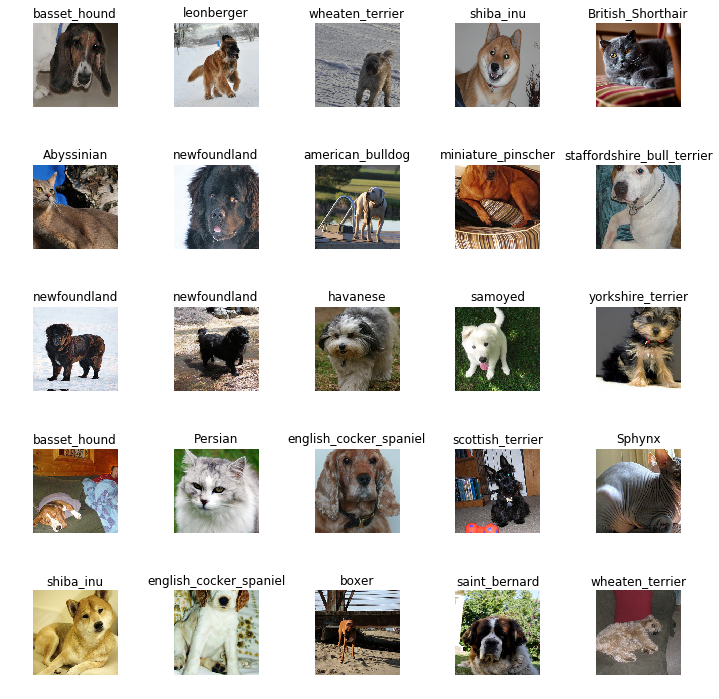

In [14]:
data.show_batch(rows=5, figsize=(10,10))

In [15]:
print(data.classes)

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


In [16]:
len(data.classes)

37

### Training using ResNet34

In [17]:
learn = cnn_learner(data, models.resnet34, metrics = error_rate)

In [18]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [20]:
learn.fit_one_cycle(2)

epoch     train_loss  valid_loss  error_rate  time    
0         0.329572    0.219431    0.075778    00:59     
1         0.260257    0.201992    0.065629    00:56     


- fit: Fit the model on this learner with lr learning rate, wd weight decay for epochs with callbacks.
- fit_one_cycle: Fit a model following the 1cycle policy.

### Result

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

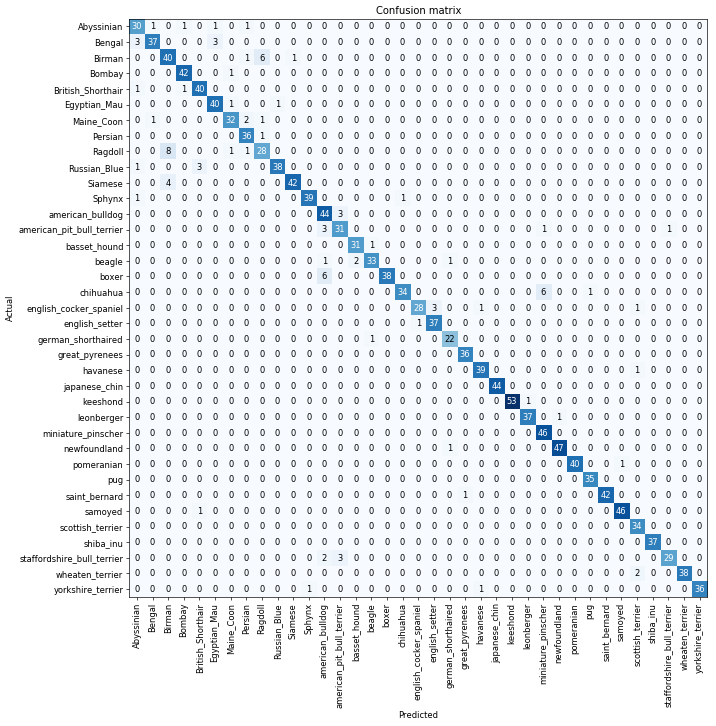

In [23]:
#confusion matrix
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [25]:
losses, idxs = interp.top_losses()

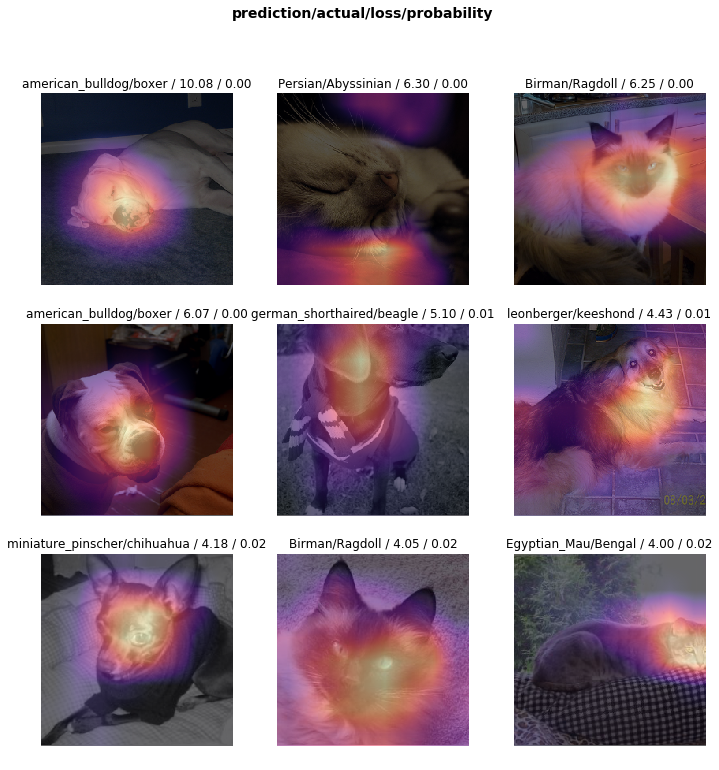

In [28]:
#see top 9 losses from the data
interp.plot_top_losses(9)

In [31]:
#see the most confused classifications
interp.most_confused(min_val=2)

[('Ragdoll', 'Birman', 8),
 ('Birman', 'Ragdoll', 6),
 ('boxer', 'american_bulldog', 6),
 ('chihuahua', 'miniature_pinscher', 6),
 ('Siamese', 'Birman', 4),
 ('Bengal', 'Abyssinian', 3),
 ('Bengal', 'Egyptian_Mau', 3),
 ('Russian_Blue', 'British_Shorthair', 3),
 ('american_bulldog', 'american_pit_bull_terrier', 3),
 ('american_pit_bull_terrier', 'american_bulldog', 3),
 ('english_cocker_spaniel', 'english_setter', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3),
 ('Maine_Coon', 'Persian', 2),
 ('beagle', 'basset_hound', 2),
 ('staffordshire_bull_terrier', 'american_bulldog', 2),
 ('wheaten_terrier', 'scottish_terrier', 2)]

In [34]:
learn.save('stage-1')

save: Save model and optimizer state

### Fine-tuning learning rates

In [32]:
learn.unfreeze()

unfreeze: Unfreeze entire model. Sets every layer group to trainable 

In [33]:
learn.fit_one_cycle(1)

epoch     train_loss  valid_loss  error_rate  time    
0         0.501452    0.293189    0.093369    01:16     


In [35]:
#load our model and optimizer state
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244)
y: CategoryList
Egyptian_Mau,scottish_terrier,newfoundland,yorkshire_terrier,pomeranian
Path: /home/jupyter/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244)
y: CategoryList
shiba_inu,leonberger,saint_bernard,beagle,Bengal
Path: /home/jupyter/.fastai/data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_s

#### Model Fitting Methods

- lr_find
- lr_recorder.plot

In [37]:
learn.lr_find()

epoch     train_loss  valid_loss  error_rate  time    
0         0.931997    #na#        00:48       
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


lr_find: Explore lr from start_lr to end_lr over num_it iterations in learn.

Exception: Error: `libsixel` is needed. See https://github.com/saitoha/libsixel

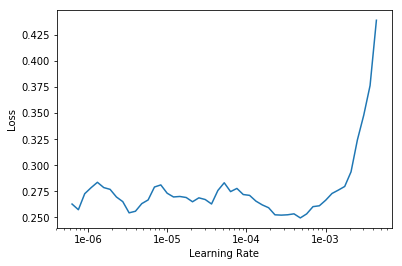

In [39]:
learn.recorder.plot()

recorder.plot : LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.

In [40]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch     train_loss  valid_loss  error_rate  time    
0         0.239924    0.236919    0.077131    01:15     
1         0.203305    0.229410    0.066306    01:15     


### Result again

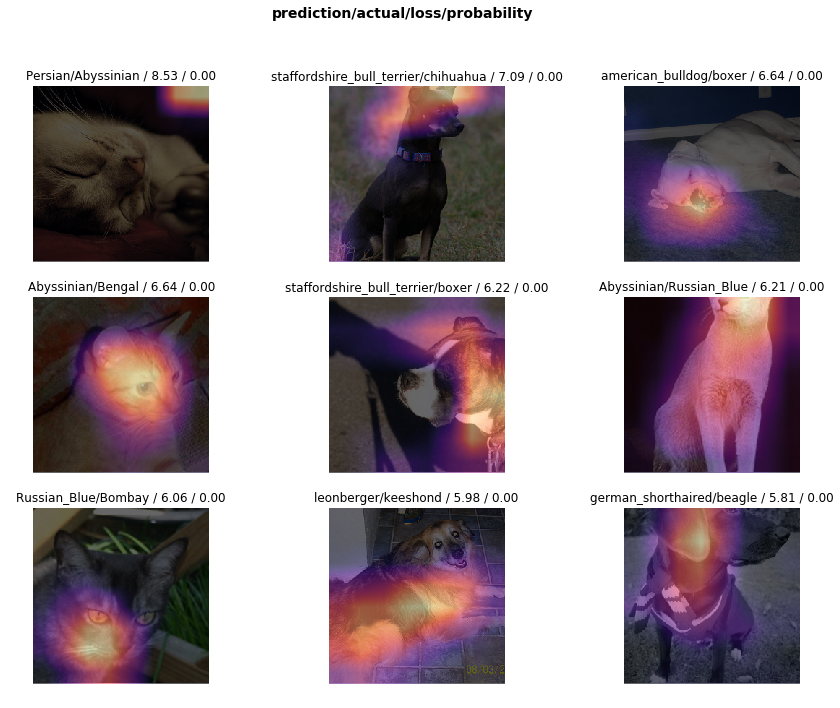

In [41]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
interp.plot_top_losses(9, figsize=(15,11))

In [42]:
interp.most_confused(min_val=2)

[('Ragdoll', 'Birman', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('Bengal', 'Abyssinian', 4),
 ('Siamese', 'Birman', 4),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 4),
 ('american_bulldog', 'american_pit_bull_terrier', 3),
 ('american_bulldog', 'staffordshire_bull_terrier', 3),
 ('english_cocker_spaniel', 'english_setter', 3),
 ('Birman', 'Siamese', 2),
 ('Russian_Blue', 'Abyssinian', 2),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 2),
 ('basset_hound', 'beagle', 2),
 ('boxer', 'american_bulldog', 2),
 ('english_cocker_spaniel', 'newfoundland', 2),
 ('english_setter', 'english_cocker_spaniel', 2),
 ('keeshond', 'leonberger', 2),
 ('miniature_pinscher', 'chihuahua', 2),
 ('yorkshire_terrier', 'havanese', 2)]

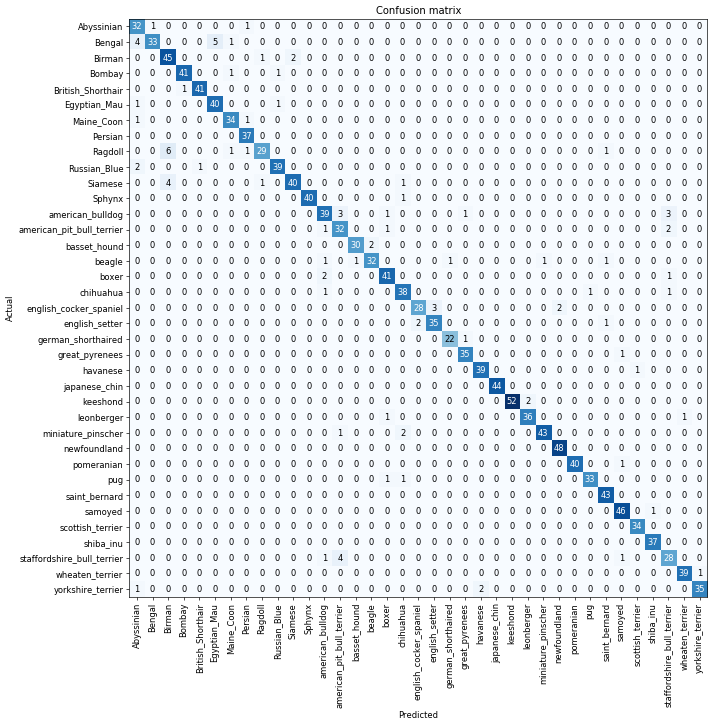

In [43]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

#### The End